## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

---


## Setup and Imports

1. Importing libraries
2. Useful functions definition

joy

sadness

anger

fear

love

surprise

In [4]:
%matplotlib inline
!pip install nlp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random



# show accuracy and loss of train data and validation data trainings
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# show confusion matrix between true and predicted labels
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [5]:
import nlp
!pip install datasets

from datasets import load_dataset

try:
    dataset = load_dataset("emotion")
except Exception as e:
    print("Error loading dataset:", e)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [8]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets, labels

In [9]:
tweets, labels = get_tweet(train)

In [10]:
for i in range(5):
  print(f"('{tweets[i]}', '{labels[i]}')")

('i didnt feel humiliated', '0')
('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', '0')
('im grabbing a minute to post i feel greedy wrong', '3')
('i am ever feeling nostalgic about the fireplace i will know that it is still on the property', '2')
('i am feeling grouchy', '3')


## Tokenizer

1. Tokenizing the tweets

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [12]:
tokenizer=Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [13]:
print(tweets[1])
tokenizer.texts_to_sequences([tweets[1]])

i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake


[[2,
  40,
  101,
  60,
  8,
  15,
  494,
  5,
  15,
  3496,
  553,
  32,
  60,
  61,
  128,
  148,
  76,
  1480,
  4,
  22,
  1255]]

## Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

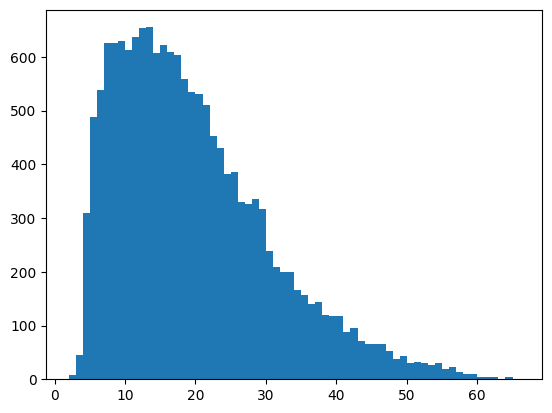

In [14]:
import matplotlib.pyplot as plt

lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [15]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [17]:
padded_train_seq=get_sequences(tokenizer, tweets)

In [18]:
padded_train_seq[1]

array([   2,   40,  101,   60,    8,   15,  494,    5,   15, 3496,  553,
         32,   60,   61,  128,  148,   76, 1480,    4,   22, 1255,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

## Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [19]:
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


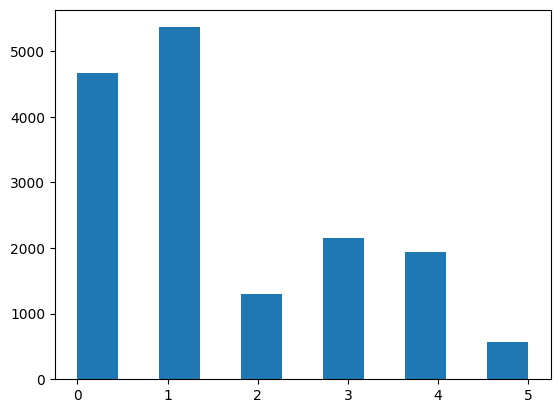

In [20]:
plt.hist(labels, bins=11)
plt.show()

In [21]:
class_to_index=dict((c,i) for i,c in enumerate(classes))
index_to_class=dict((v,k) for k,v in class_to_index.items())

In [22]:
class_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [23]:
index_to_class

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [24]:
names_to_indexes=lambda labels: np.array([class_to_index.get(x) for x in labels ])

In [25]:
import numpy as np

train_labels= names_to_indexes(labels)

In [26]:
train_labels[0:5]

array([0, 0, 3, 2, 3])

## Creating the Model

1. Creating the model
2. Compiling the model

In [27]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(input_dim=10000, output_dim=16, input_length=maxlen),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=20)),
  tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Training the Model

1. Preparing a validation set
2. Training the model

In [29]:
val_tweets, val_labels = get_tweet(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_indexes(val_labels)

In [30]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(0))

In [31]:
hypothesis = model.fit(
    x=padded_train_seq,
    y=train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3626 - loss: 1.5367 - val_accuracy: 0.6570 - val_loss: 0.8417
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.7220 - loss: 0.6859 - val_accuracy: 0.7480 - val_loss: 0.6618
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8339 - loss: 0.4581 - val_accuracy: 0.8375 - val_loss: 0.4998
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9085 - loss: 0.2718 - val_accuracy: 0.8720 - val_loss: 0.4190
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9437 - loss: 0.1843 - val_accuracy: 0.8800 - val_loss: 0.3991
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9603 - loss: 0.1301 - val_accuracy: 0.8900 - val_loss: 0.3709
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9642 - loss: 0.1143 - val_accuracy: 0.8870 - val_loss: 0.3669
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9715 - loss: 0.0903 - val

## Evaluating the Model

1. Visualizing training history
2. Preparing a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

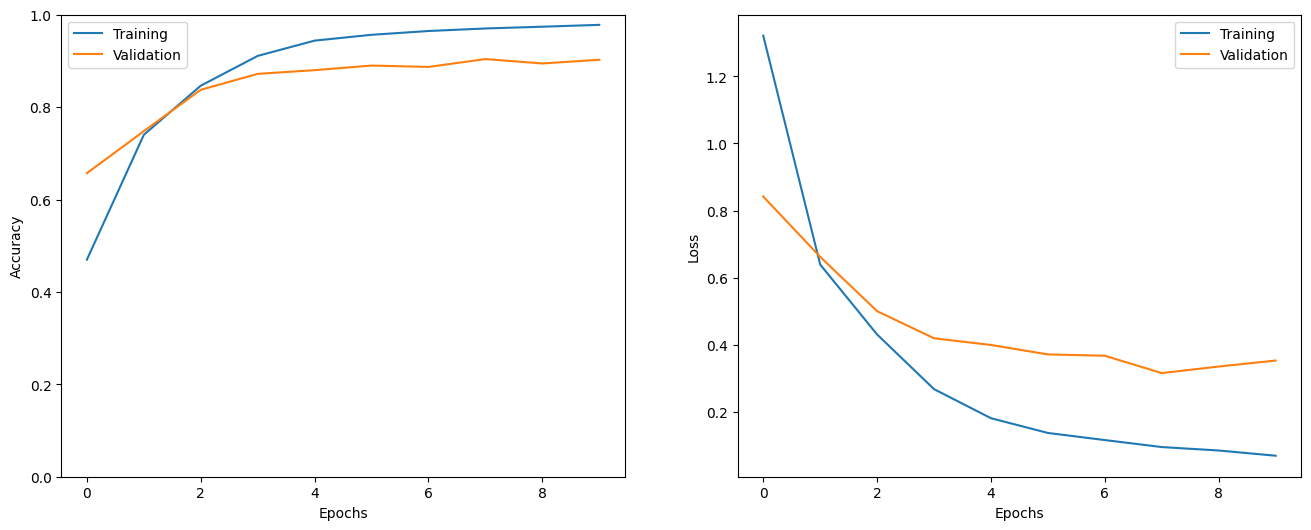

In [32]:
show_history(hypothesis)

In [33]:
test_tweets, test_labels = get_tweet(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_indexes(test_labels)

In [34]:
_ = model.evaluate(x=test_sequences, y=test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8851 - loss: 0.4216


In [35]:
import random
i = random.randint(0, len(test_labels)-1)

print(f'Tweet : {test_tweets[i]}')
print(f'Emotion : {index_to_class[test_labels[i]]}')

i_prediction = model.predict(np.expand_dims(test_sequences[i], axis=0))[0]
predicted_class = index_to_class[np.argmax(i_prediction).astype('uint8')]

print(f'\nTweet : {test_tweets[i]}')
print(f'Predicted Emotion : {predicted_class}')

Tweet : i feel threatened when other people do not believe that
Emotion : 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step

Tweet : i feel threatened when other people do not believe that
Predicted Emotion : 4


In [36]:
predictions = model.predict(test_sequences)
predicted_classes = np.argmax(predictions, axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


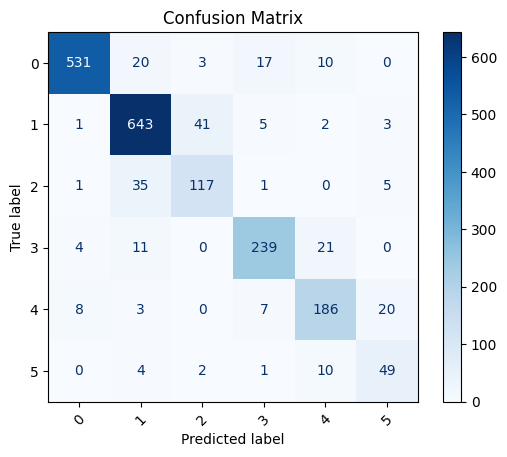

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.xticks(rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

show_confusion_matrix(test_labels, predicted_classes, list(classes))
